# Should we be worried about our Arctic OLR methods?

Panel a: Compare the “true” uncertainty with estimates from the Weatherhead uncertainty.  
Panel b: Plot the fraction of ensemble members with uncertainty greater than the “true” uncertainty to look for biases from the Weatherhead metric.  

_I will use Arctic surface temperature as my example here because I haven't pre-processed any LENS data yet, but surface temperature is stored across all of the large ensembles._

Some of this code was developed in spectral_ice/fig10_OLRvariabilitychange.ipynb

### Do imports

In [1]:
import sys
# Add common resources folder to path
sys.path.append('/glade/u/home/jonahshaw/Scripts/git_repos/climatetrend_uncertainty/')
sys.path.append('/glade/u/home/jonahshaw/Scripts/git_repos/climatetrend_uncertainty/Common/') # is this good or not good. I should reorg.
# sys.path.append("/home/jonahks/git_repos/netcdf_analysis/Common/")

from imports import (
    np, xr, plt, sns, os, 
    datetime, gridspec, 
    Iterable, cmaps, glob, copy,
    dask,pd
    )

from functions import (
    add_weights,
    to_png, stats,
    multidim_groupby_map,
    reindex_time_to_monthyear,
    reindex_time_to_year,
    )

from collections import deque
%matplotlib inline

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Load Data

### Load pre-processed timeseries

In [2]:
tseries_savedir = '/glade/u/home/jonahshaw/w/LENS/CESM1-LE/ArcticTimeSeries/'

cesm1_pic_ds = xr.open_dataset('%s/CESM1_PIControl_ArcticTimeSeries.nc' % tseries_savedir)

In [3]:
cesm1_pic_olr = cesm1_pic_ds['FLUT']

### Load pre-processed trends

In [4]:
## fig10_OLRvariabilitychange.ipynb for creation

spectral_olr_dir = '/glade/u/home/jonahshaw/Scripts/git_repos/spectral_ice/paper_figures'

trends_allstartyear_allduration = xr.open_dataarray('%s/%s' % (spectral_olr_dir,'unforced_OLR_trends_month_duration_startyear.nc'))


In [5]:
# These functions allow me to calculate a percentile across all variables for each month of the year. 
# Essentially a poorman's version of creating the numpy.percentile function within xarray. But it works!

def xr_percentile_wrapper(nparray,q,axis):
    '''
    Wrapper for a non-xarray function so that it returns a DataArray object.
    I am using nanpercentile here because it handles all cases.
    '''
    return xr.DataArray(np.nanpercentile(nparray,q=q,axis=axis))

def percentile_monthly_wrapper(data,dim,q,axis):
    
    return data.groupby(dim).map(xr_percentile_wrapper,q=q,axis=axis)

Explicitly calculate the trend uncertainty from the unforced trends from the PI-Control simulation.

In [6]:
PIC_trendunc_low = trends_allstartyear_allduration.groupby('duration').map(percentile_monthly_wrapper,dim='month',q=2.5,axis=0).transpose('month','duration')
PIC_trendunc_high = trends_allstartyear_allduration.groupby('duration').map(percentile_monthly_wrapper,dim='month',q=97.5,axis=0).transpose('month','duration')

### Load pre-processed variability (Leroy)

This comes from calculating $\sigma_{var}$ and $\tau_{var}$ for the full PI-Control simulation.

In [7]:
lens_file_path = '/glade/u/home/jonahshaw/Scripts/git_repos/spectral_ice/lens_variability_vars.nc'

In [8]:
lens_data = xr.open_dataset(lens_file_path)

In [9]:
'''
$$ \sigma_{\hat{m}} = \left[ \frac{12}{T^3} \sigma_{var}^2 \tau_{var} \right]^{1/2} $$
'''

lens_uncertainty_olr = lens_data.sel(variable='FLUT')
net_uncertainty_olr = lens_uncertainty_olr['stddev']**2 * lens_uncertainty_olr['tauvar']

lens_trend_uncertainty_olr = np.sqrt(12 * net_uncertainty_olr / (trends_allstartyear_allduration['duration']**(3)))

$$ \sigma_{\hat{m}} = \left[ \frac{12}{T^3} \sigma_{var}^2 \tau_{var} \right]^{1/2} $$

### Calculate variability (Weatherhead)

#### Pre-define functions

In [10]:
# Define a function for standardizing data to be used before calculating an autocorrelation
def standardize(data,testing=False):
    ''' Standardize the data. '''
    
    # if data.std()==0: # edge case that the standard deviation is zero
    if np.isclose(data.std(),0,atol=1e-5): # edge case that the standard deviation is zero
        data_std = (data - data.mean())
        np.testing.assert_allclose(data_std.mean(),0,atol=1e-5)
        return data_std
    else:
        data_std = (data - data.mean()) / data.std()
    
    if testing:
        print(data)
        print(data_std)
    
    try:
        np.testing.assert_allclose(data_std.mean(),0,atol=1e-5)
        np.testing.assert_allclose(data_std.std(),1,atol=1e-5)
    except:
        print(data_std[np.isnan(data_std)])
        print(data_std.nanmean())
        print(data_std.nanstd())
        raise AssertionError()
    
    return data_std

In [11]:
def simple_detrend(tseries,dim):
    '''
    Pass a timeseries and the dimension to detrend along.
    Example use: tsubset_linearized = tsubset.groupby('ens').map(simple_detrend,dim='year') # detrend each ensemble time subseries
    '''
    
    polyfit = tseries.polyfit(dim=dim,deg=1) # take a linear fit
    slopes  = polyfit['polyfit_coefficients'] # pull out the slope from the linear fit
    
    linearized_tseries = slopes.sel(degree=1)*tseries[dim] + slopes.sel(degree=0) # construct the linear fit
    detrended_tseries  = tseries - linearized_tseries # remove the linear fit to detrend the timeseries
    
    return detrended_tseries

In [12]:
def linear_polyfit(ds,dim='time.year'):
    '''
    Simple wrapped for xarray's polyfit function because I couldn't figure out how to pass arguments...
    allens_all_tseries_preproc.groupby('time.month').map(xr.Dataset.polyfit,args=('time',1)) # this should work if you use xr.DataArray?
    '''
    # ds['time'] = ds[dim] # reassign the time coordinate so that the polyfit gets units right
    ds['time'] = ds['time.year'] # reassign the time coordinate so that the polyfit gets units right, this is the old code
    
    return ds.polyfit(dim='time',deg=1)

In [13]:
def calc_autocorr(data):
        
    # standardize the data
    data_std = standardize(data) # Standardize the timeseries so the autocorrelation has correct units
    autocorr = np.correlate(data_std,data_std,mode='same') / len(data_std)
    
    return autocorr

def calc_lag1_autocorr(data):
    
    autocorr = calc_autocorr(data)
    
    _lag1_index = len(autocorr) // 2 + 1 # The lag-1 autocorrelation is just off the center of the autocorrelation function, get this index
    _lag1_autocorr = autocorr[_lag1_index] # Get the lag-1 autocorrelation
    
    return xr.DataArray(_lag1_autocorr) # convert back to a dataarray object so xarray can try to concatenate

# def calc_tauvar_wrapper(data):
    
#     return xr.DataArray(calc_tauvar(calc_autocorr(data),verbose=False))

def calc_tauvar_wrapper(data):
    
    return xr.DataArray(calc_tauvar2(calc_autocorr(data)))

In [14]:
cesm1_olr_lag1_monthly = cesm1_pic_olr.groupby('time.month').map(calc_lag1_autocorr)
cesm1_olr_lag1_annual  = calc_lag1_autocorr(cesm1_pic_olr.groupby('time.year').mean(dim='time'))

cesm1_olr_lag1 = xr.concat([cesm1_olr_lag1_monthly,cesm1_olr_lag1_annual.assign_coords({'month':13}).expand_dims('month',axis=0)],dim='month')

cesm1_olr_tauvar_wea = (1 + cesm1_olr_lag1) / (1 - cesm1_olr_lag1)

cesm1_olr_sigmavar_monthly = cesm1_pic_olr.groupby('time.month').std()
cesm1_olr_sigmavar_annual  = cesm1_pic_olr.groupby('time.year').mean(dim='time').std()

cesm1_olr_sigmavar = xr.concat([cesm1_olr_sigmavar_monthly,cesm1_olr_sigmavar_annual.assign_coords({'month':13}).expand_dims('month',axis=0)],dim='month')


In [15]:
net_uncertainty_olr_wea = cesm1_olr_sigmavar**2 * cesm1_olr_tauvar_wea

lens_trend_uncertainty_olr_wea = np.sqrt(12 * net_uncertainty_olr_wea / (trends_allstartyear_allduration['duration']**(3)))

#### Plot to make sense of things

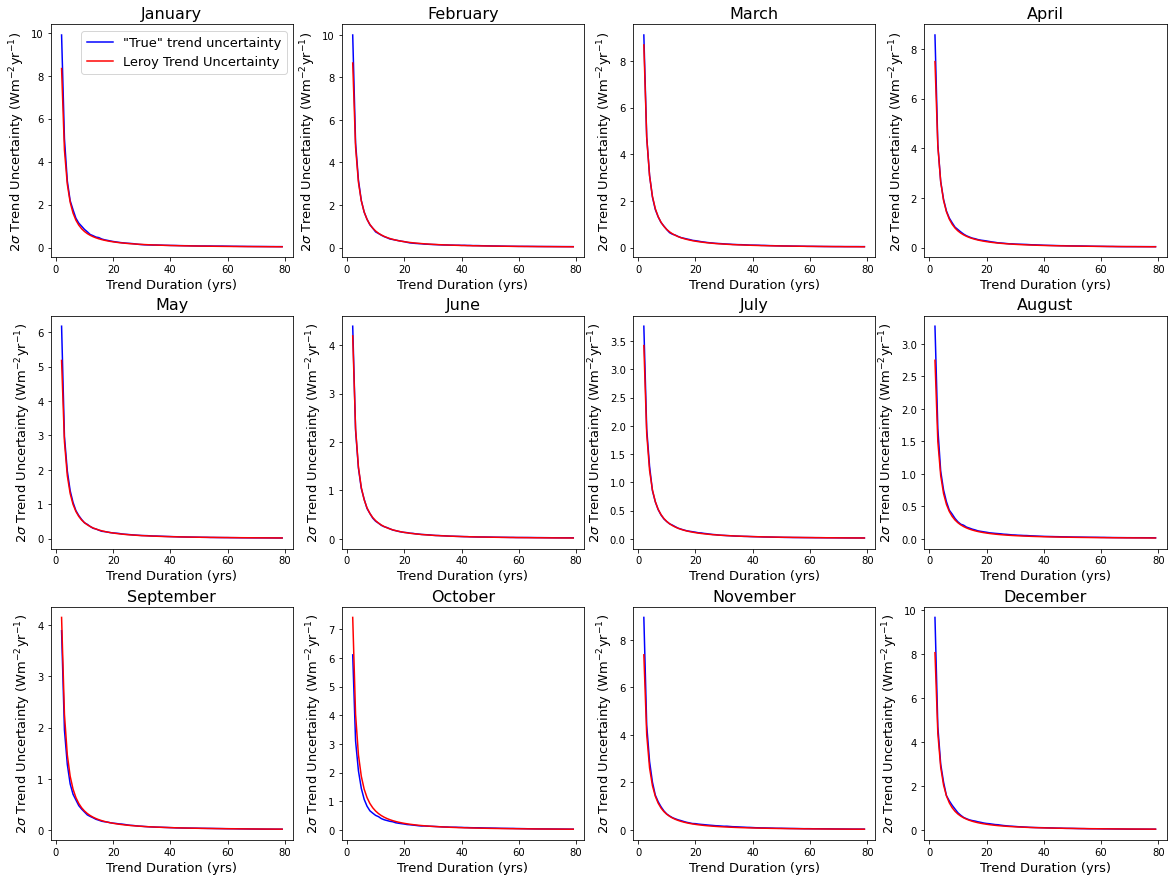

In [16]:
fig,axs = plt.subplots(nrows=3,ncols=4,figsize=(20,15))
axs = axs.flat

month_labels = ['January','February','March','April','May','June','July','August','September','October','November','December']\

for _month_lens_full,_month_lens_leroy,_month_label,_ax in zip(PIC_trendunc_high,lens_trend_uncertainty_olr,month_labels,axs):
    
    # _ax.plot(_month_low.duration,_month_low,color='blue')
    _ax.plot(_month_lens_full.duration,_month_lens_full,color='blue',label='"True" trend uncertainty')
    _ax.plot(_month_lens_leroy.duration,_month_lens_leroy*1.96,color='red',label='Leroy Trend Uncertainty')
    
    _ax.set_title(_month_label,fontsize=16)
    _ax.set_xlabel('Trend Duration (yrs)',fontsize=13)
    _ax.set_ylabel('$2\sigma$ Trend Uncertainty (Wm$^{-2}$yr$^{-1}$)',fontsize=13)

axs[0].legend(fontsize=13)
fig.subplots_adjust(hspace=0.25)

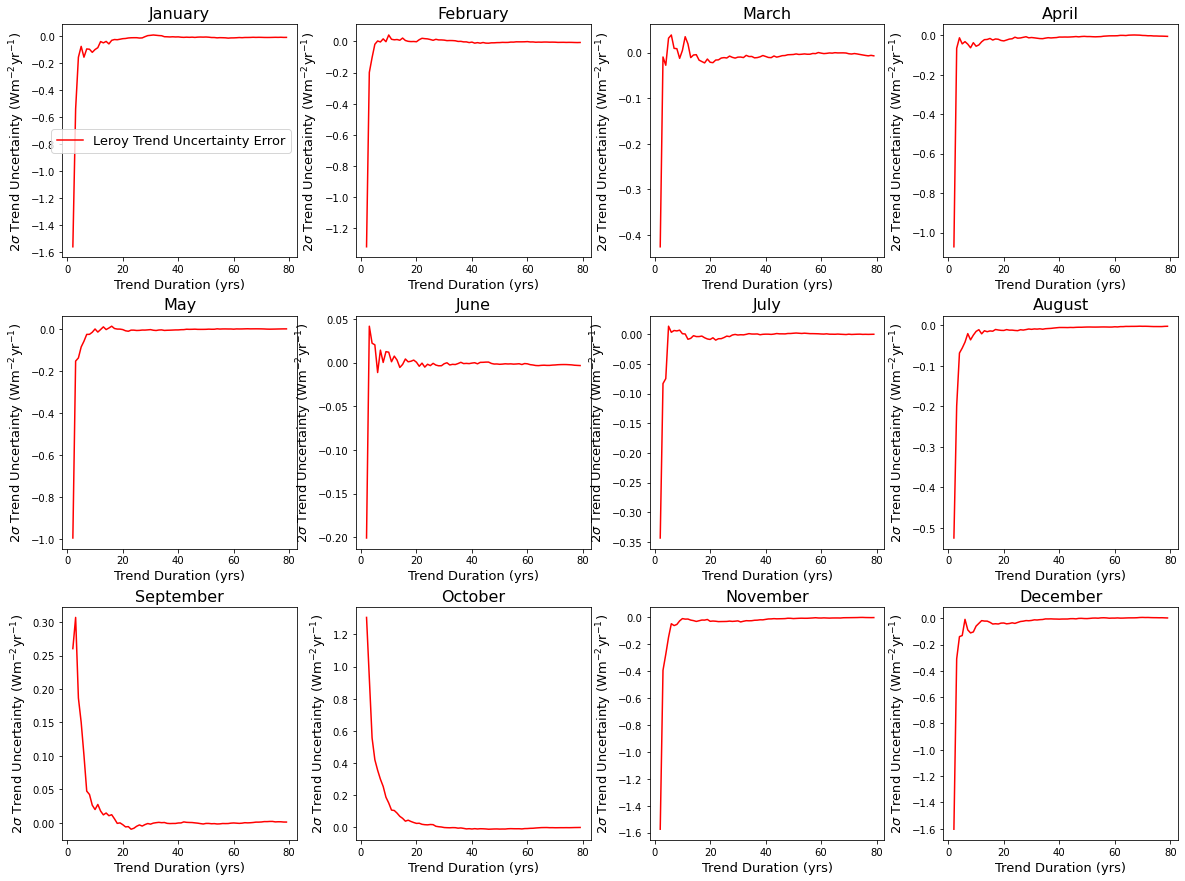

In [17]:
fig,axs = plt.subplots(nrows=3,ncols=4,figsize=(20,15))
axs = axs.flat

month_labels = ['January','February','March','April','May','June','July','August','September','October','November','December']\

for _month_lens_full,_month_lens_leroy,_month_label,_ax in zip(PIC_trendunc_high,lens_trend_uncertainty_olr,month_labels,axs):
    
    unc_error = _month_lens_leroy*1.96 - _month_lens_full
    
    _ax.plot(unc_error.duration,unc_error,color='red',label='Leroy Trend Uncertainty Error')
    
    _ax.set_title(_month_label,fontsize=16)
    _ax.set_xlabel('Trend Duration (yrs)',fontsize=13)
    _ax.set_ylabel('$2\sigma$ Trend Uncertainty (Wm$^{-2}$yr$^{-1}$)',fontsize=13)

axs[0].legend(fontsize=13)
fig.subplots_adjust(hspace=0.25,wspace=0.25)

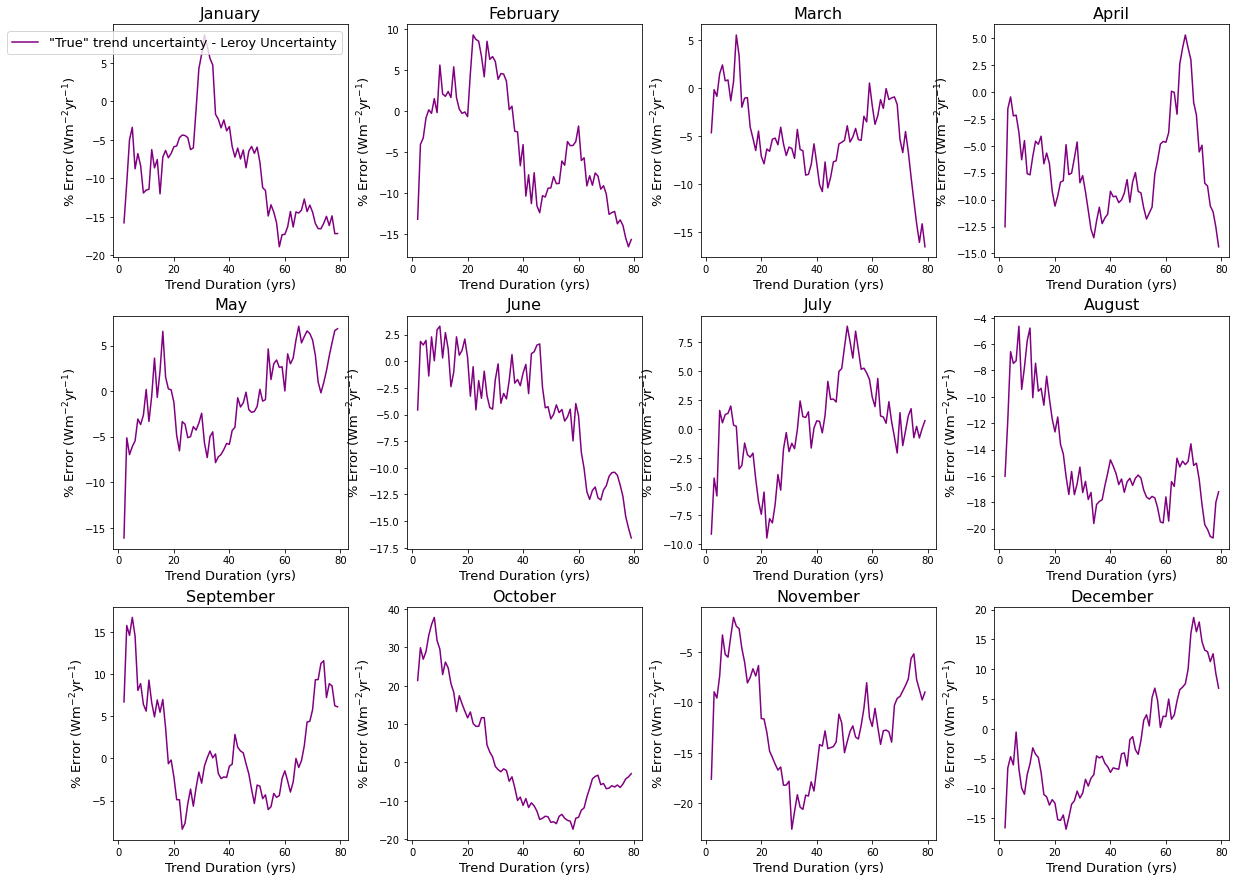

In [18]:
fig,axs = plt.subplots(nrows=3,ncols=4,figsize=(20,15))
axs = axs.flat

month_labels = ['January','February','March','April','May','June','July','August','September','October','November','December']\

for _month_lens_full,_month_lens_leroy,_month_label,_ax in zip(PIC_trendunc_high,lens_trend_uncertainty_olr,month_labels,axs):
    
    # _ax.plot(_month_low.duration,_month_low,color='blue')
    _unc_error = (1.96*_month_lens_leroy) - _month_lens_full
    _unc_error_pct = 100*((1.96*_month_lens_leroy) - _month_lens_full) / _month_lens_full
    _ax.plot(_unc_error_pct.duration,_unc_error_pct,color='purple',label='"True" trend uncertainty - Leroy Uncertainty')
        
    _ax.set_title(_month_label,fontsize=16)
    _ax.set_xlabel('Trend Duration (yrs)',fontsize=13)
    _ax.set_ylabel('% Error (Wm$^{-2}$yr$^{-1}$)',fontsize=13)

axs[0].legend(fontsize=13)
fig.subplots_adjust(hspace=0.25,wspace=0.25)

#### Thoughts

These plots collectively show us that the methods we used appear to perform well generally. Specifically, errors appear to be small and unbiased at the timescales of emergence (20-40 years). One important caveat is September and October, where there does appear to be a systemic bias in the trend uncertainty. These are the months with the largest $\tau_{var}$, indicating that the Leroy/Phojanamongkolkij metric is over-estimating the influence of memory on the trend uncertainty. Another option is that, the Leroy metric is worse than the Weatherhead metric in this case.

__An important note is that the annually-averaged trends have much more memory than any of the individual months. This means that the Leroy estimate is likely even more biased. This could influence our results pertaining to the emergence of annually averaged OLR.__

#### Repeat plots with the Weatherhead uncertainty

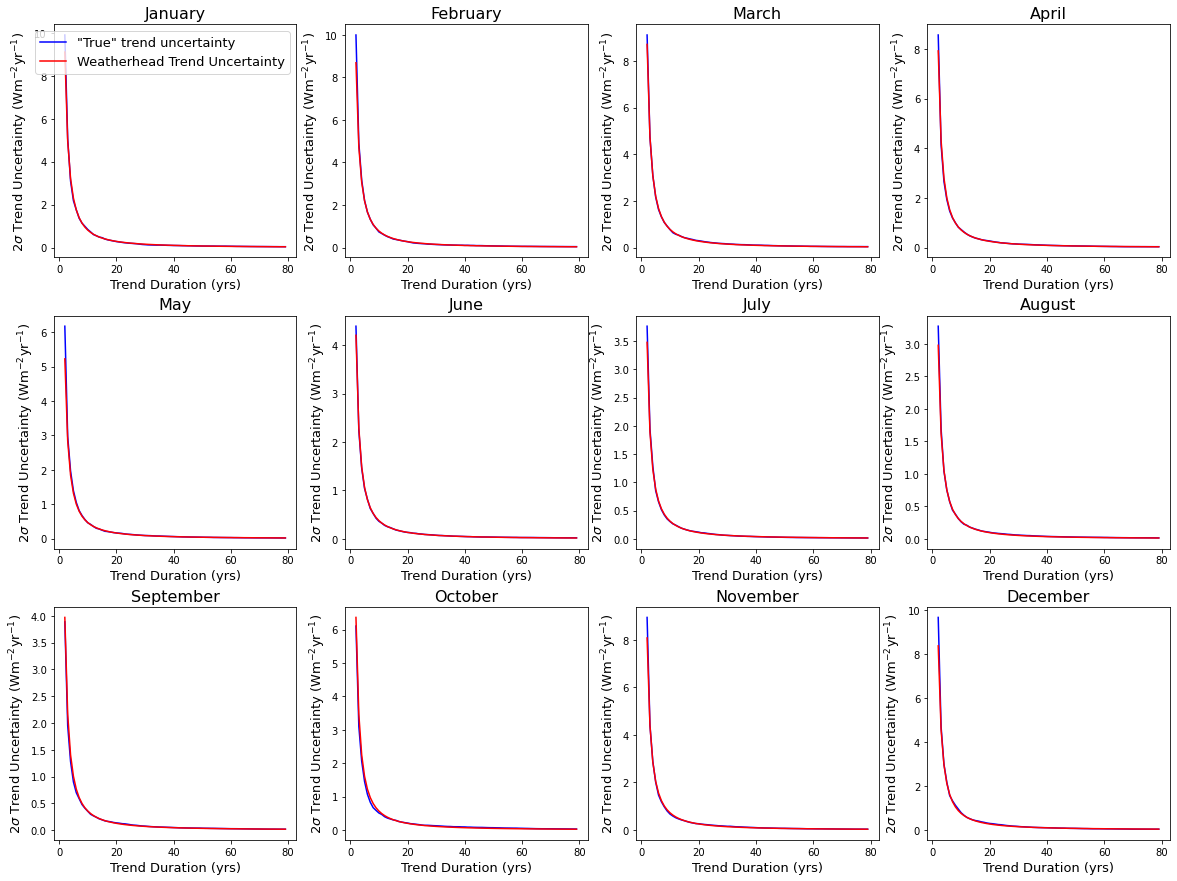

In [19]:
fig,axs = plt.subplots(nrows=3,ncols=4,figsize=(20,15))
axs = axs.flat

month_labels = ['January','February','March','April','May','June','July','August','September','October','November','December']\

for _month_lens_full,_month_lens_wea,_month_label,_ax in zip(PIC_trendunc_high,lens_trend_uncertainty_olr_wea,month_labels,axs):
    
    # _ax.plot(_month_low.duration,_month_low,color='blue')
    _ax.plot(_month_lens_full.duration,_month_lens_full,color='blue',label='"True" trend uncertainty')
    _ax.plot(_month_lens_wea.duration,_month_lens_wea*1.96,color='red',label='Weatherhead Trend Uncertainty')
    
    _ax.set_title(_month_label,fontsize=16)
    _ax.set_xlabel('Trend Duration (yrs)',fontsize=13)
    _ax.set_ylabel('$2\sigma$ Trend Uncertainty (Wm$^{-2}$yr$^{-1}$)',fontsize=13)

axs[0].legend(fontsize=13)
fig.subplots_adjust(hspace=0.25)

The Weatherhead uncertainty nails it!

Text(0.5, 0.08, 'Trend Duration (years)')

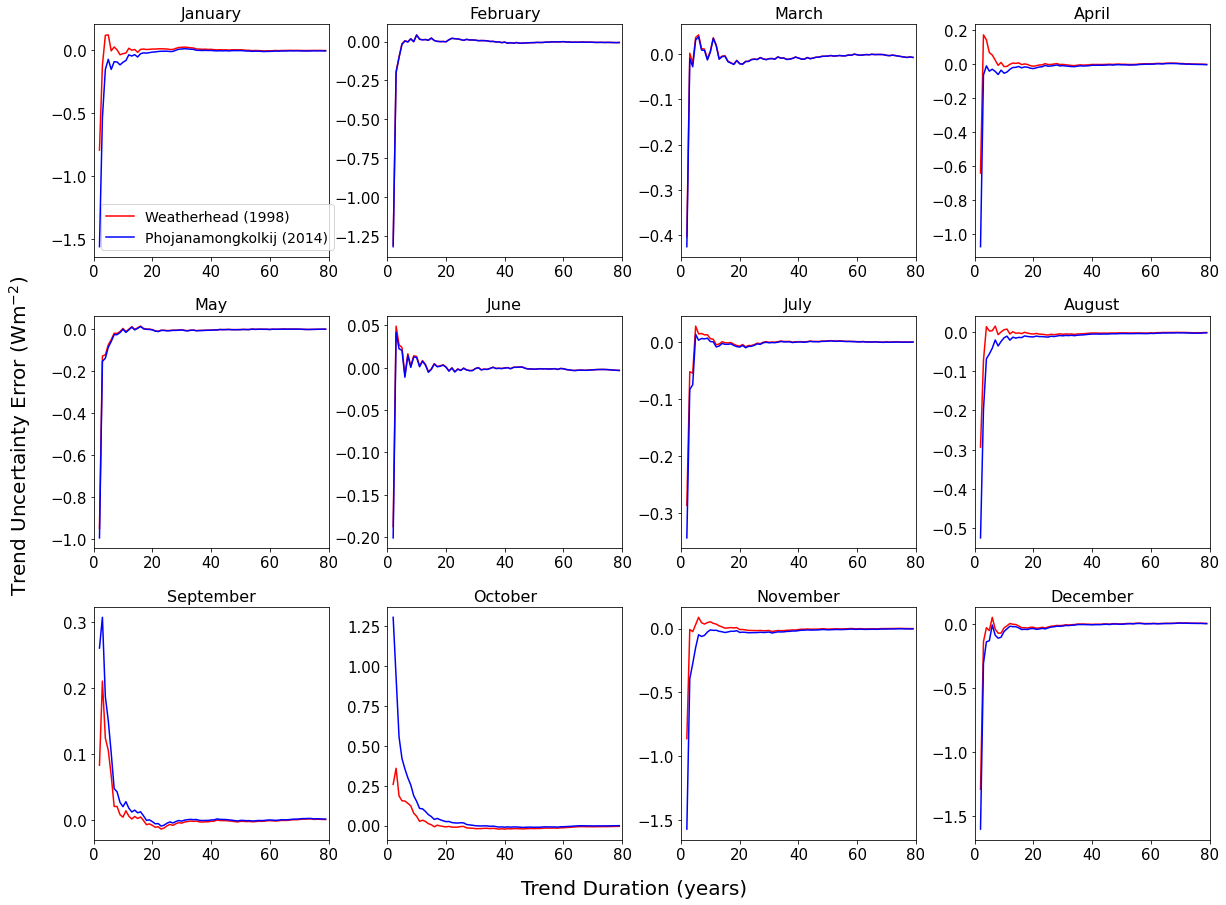

In [24]:
fig,axs = plt.subplots(nrows=3,ncols=4,figsize=(20,15))
axs = axs.flat

month_labels = ['January','February','March','April','May','June','July','August','September','October','November','December']\

for _month_lens_full,_month_lens_leroy,_month_lens_wea,_month_label,_ax in zip(PIC_trendunc_high,
                                                             lens_trend_uncertainty_olr,
                                                             lens_trend_uncertainty_olr_wea,
                                                             month_labels,axs):
    
    unc_error_wea   = _month_lens_wea*1.96 - _month_lens_full
    unc_error_leroy = _month_lens_leroy*1.96 - _month_lens_full
    
    _ax.plot(unc_error_wea.duration,unc_error_wea,color='red',label='Weatherhead (1998)')
    _ax.plot(unc_error_leroy.duration,unc_error_leroy,color='blue',label='Phojanamongkolkij (2014)')
    
    _ax.set_title(_month_label,fontsize=16)
    
    _ax.set_xticks(np.arange(0,81,20))#,fontsize=14)
    _ax.tick_params(axis='both', labelsize=15)
    _ax.set_xlim(0,80)
    
axs[0].legend(fontsize=14)
fig.subplots_adjust(hspace=0.25,wspace=0.25)

fig.text(x=0.065,y=0.5,s='Trend Uncertainty Error (Wm$^{-2}$)',rotation=90,fontsize=20,va='center')
# fig.text(x=0.065,y=0.5,s='Error in OLR Trend Uncertainty 95% Confidence Interval (Wm$^{-2}$)',rotation=90,fontsize=20,va='center')
fig.text(x=0.5,y=0.08,s='Trend Duration (years)',rotation=0,fontsize=20,va='center',ha='center')

In [25]:
to_png(file=fig,filename='fig_trenduncertainty_comparison',dpi=300,ext='pdf',bbox_inches='tight')

Looking closer, the Weatherhead metric is much better but still has the opposite sign of errors.

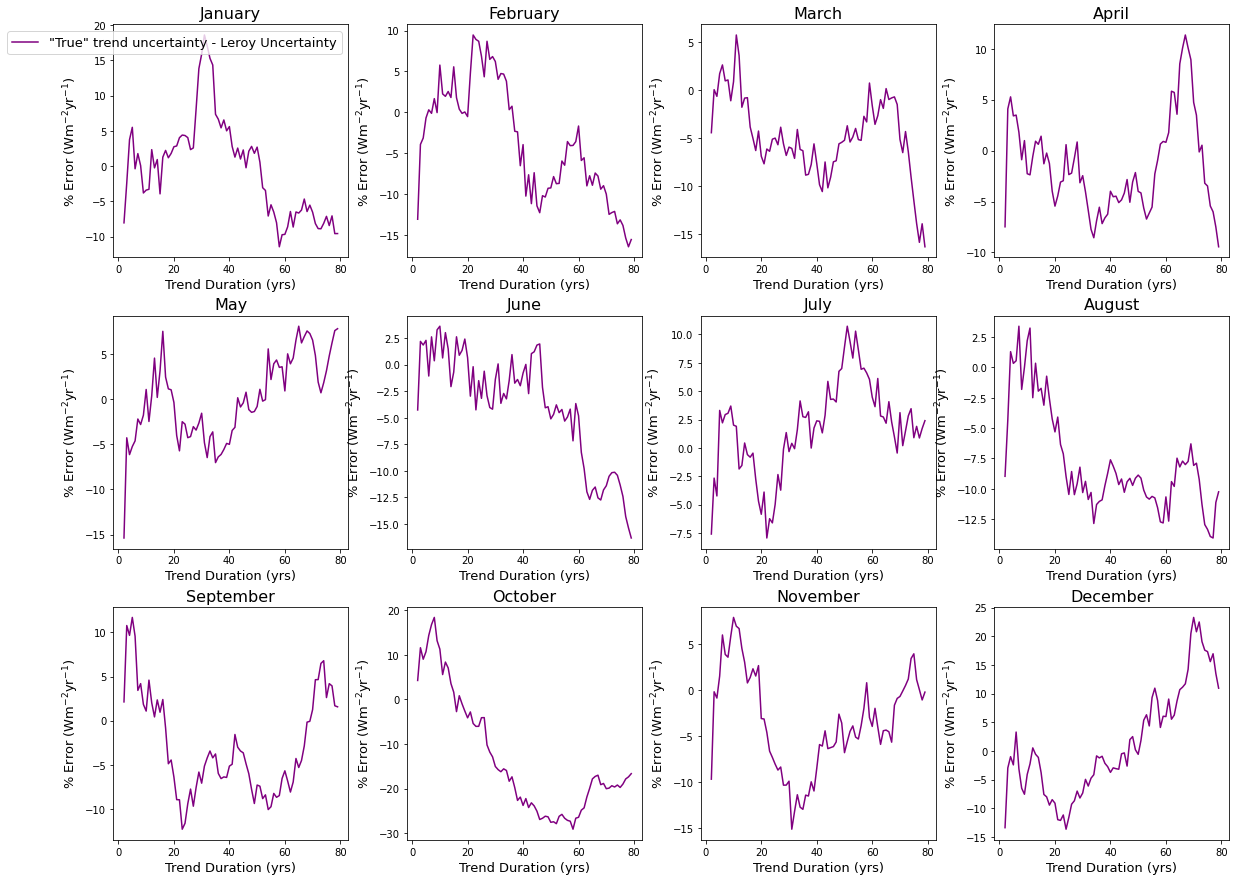

In [21]:
fig,axs = plt.subplots(nrows=3,ncols=4,figsize=(20,15))
axs = axs.flat

month_labels = ['January','February','March','April','May','June','July','August','September','October','November','December']\

for _month_lens_full,_month_lens_wea,_month_label,_ax in zip(PIC_trendunc_high,lens_trend_uncertainty_olr_wea,month_labels,axs):
    
    # _ax.plot(_month_low.duration,_month_low,color='blue')
    _unc_error = (1.96*_month_lens_wea) - _month_lens_full
    _unc_error_pct = 100*((1.96*_month_lens_wea) - _month_lens_full) / _month_lens_full
    _ax.plot(_unc_error_pct.duration,_unc_error_pct,color='purple',label='"True" trend uncertainty - Leroy Uncertainty')
    
    # _ax.plot(_month_high.duration,_month_high,color='blue',label='"True" trend uncertainty')
    # _ax.plot(_month_lens_leroy.duration,_month_lens_leroy*1.96,color='red',label='Leroy Trend Uncertainty')
    
    _ax.set_title(_month_label,fontsize=16)
    _ax.set_xlabel('Trend Duration (yrs)',fontsize=13)
    _ax.set_ylabel('% Error (Wm$^{-2}$yr$^{-1}$)',fontsize=13)

axs[0].legend(fontsize=13)
fig.subplots_adjust(hspace=0.25,wspace=0.25)

The Weatherhead metric performs quite well. I should use this instead and can use these plots to justify it in the supplement.